# Univariate results, basic feature engineering

In this notebook the following approaches are implemented:
- no feature engineering
- minmax scaling
- differenecing
- differencing + log transforms

In [1]:
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
import pandas as pd

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate


2022-05-12 11:11:18.064165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 11:11:18.064183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

# 1. Baseline: no feature engineering / minmax only

### Need to test this cell below.

In [2]:
financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'minmax_2'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)


    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df[f'{column_to_predict}'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    original_series=scaled_input_data,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



Trial 11 Complete [00h 00m 32s]
val_loss: 0.0412568443454802

Best val_loss So Far: 0.0010443461127579213
Total elapsed time: 00h 05m 13s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
272               |80                |units 0
2                 |1                 |layers
144               |48                |units -1
0.001             |0.001             |learning_rate
208               |176               |units 1
176               |48                |units 2

Epoch 1/5
42/42 [==============================] - 4s 42ms/step - loss: 0.0316 - val_loss: 0.0199
Epoch 2/5
42/42 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/5
 1/42 [..............................] - ETA: 1s - loss: 7.2608e-04

# 2 Differencing

In [13]:
def inverted_conclusion(dates,original_values, linear_preds, svm_pred, nn_preds, lstm_preds,financial_asset,feat_engineer):
    """
    This method collects all results in a neat to display and easy to read table.
    """

    # hit rate calculations
    df_lin, lin_accuracy = hit_rate(dates,original_values,linear_preds)
    df_svm, svm_accuracy = hit_rate(dates,original_values,svm_pred)
    df_nn, nn_accuracy = hit_rate(dates,original_values,nn_preds)
    df_lstm, lstm_accuracy = hit_rate(dates,original_values,lstm_preds)

    # other eval metrics
    linear_reg_rmse = np.sqrt(mean_squared_error(original_values,linear_preds))
    linear_reg_mae = mean_absolute_error(original_values,linear_preds)
    linear_reg_mape = mean_absolute_percentage_error(original_values,linear_preds)

    svm_rmse = np.sqrt(mean_squared_error(original_values,svm_pred))
    svm_mae = mean_absolute_error(original_values,svm_pred)
    svm_mape = mean_absolute_percentage_error(original_values,svm_pred)

    nn_rmse = np.sqrt(mean_squared_error(original_values,nn_preds))
    nn_mae = mean_absolute_error(original_values,nn_preds)
    nn_mape = mean_absolute_percentage_error(original_values,nn_preds)

    lstm_rmse = np.sqrt(mean_squared_error(original_values,lstm_preds))
    lstm_mae = mean_absolute_error(original_values,lstm_preds)
    lstm_mape = mean_absolute_percentage_error(original_values,lstm_preds)

    # rows defined as dictionaries
    linear = {'model':'Linear Regression','RMSE':linear_reg_rmse,'MAE':linear_reg_mae,'MAPE':linear_reg_mape,'DA':lin_accuracy}
    svr = {'model':'SVM','RMSE':svm_rmse,'MAE':svm_mae,'MAPE':svm_mape,'DA':svm_accuracy}
    mlp = {'model':'MLP','RMSE':nn_rmse,'MAE':nn_mae,'MAPE':nn_mape,'DA':nn_accuracy}
    lstm = {'model':'LSTM','RMSE':lstm_rmse,'MAE':lstm_mae,'MAPE':lstm_mape,'DA':lstm_accuracy}

    # place into df
    df_conclusion = pd.DataFrame.from_records([linear,svr,mlp,lstm])

    # print nicely
    print(tabulate(df_conclusion, headers='keys', tablefmt="psql"))

    # save evaluation results nicely
    name = financial_asset + '_' + feat_engineer
    df_conclusion.to_csv(f'./results/univariate_single_step_ahead/{feat_engineer}/{financial_asset}_results_summary_inverted.csv')

    # save evaluation results nicely to latex table
    latex_table = tabulate(df_conclusion, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineer}/{financial_asset}_latex_table_inverted.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)


In [ ]:
financial_assets = ['S&P500','Apple','EurUsd','CrudeOil'] # AirPassengers',
feat_engineering = 'difference'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # feature engineer data
    ###################################################################################################

    df['diff'] = df[f'{column_to_predict}'].diff(periods=1)
    df['diff'].iloc[0] = 0

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df['diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df['diff'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=128)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Differenced Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # invert differencing for different models
    inverted_lin = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
    inverted_svm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_nn = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_lstm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_lin['invert_pred_value'], 
                        svm_pred=inverted_svm['invert_pred_value'], 
                        nn_preds=inverted_nn['invert_pred_value'], 
                        lstm_preds=inverted_lstm['invert_pred_value'],
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    original_series=scaled_input_data,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())
        
        # invert differencing for different models
        inverted_preds = invert_first_difference_2(
                                first_value=df[f'{column_to_predict}'].iloc[train_len],
                                predictions=inverted_predictions,
                                original=df[f'{column_to_predict}'].iloc[train_len:],
                                dates=df['Date'].iloc[train_len:]               
                                        )

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value']))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_preds['invert_pred_value'])

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = inverted_preds['value'].to_numpy()
        model_pred_results[model_name] = inverted_preds['invert_pred_value'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')



# 3. Differencing and log transforms

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


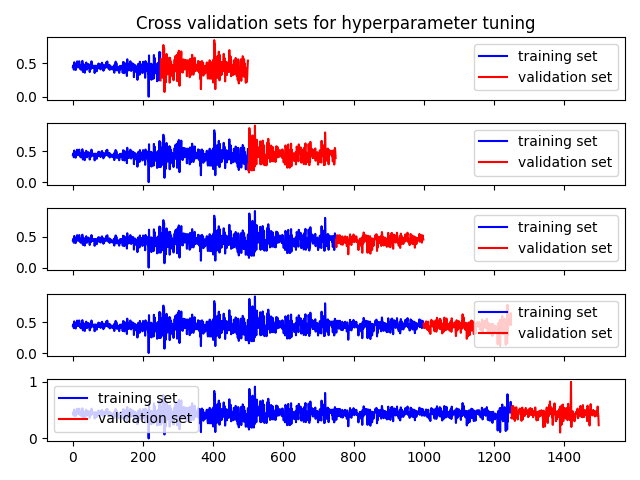

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.01940834  0.01686066  0.01228402 -0.00208128  0.0014652   0.05265472
  0.02890846 -0.0377842   0.02880057 -0.09053059]
MAPE: 1.0197491089220212
RMSE:  1.2408218433471856
MAE:  0.18609613981102718

Training support vector machine:
Model params:  {'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 1.0602445727925482
RMSE:  1.2381668607235956
MAE:  0.1889762703794563

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 260005615636.448
RMSE:  0.1627462422932664
MAE:  0.02738486769289595
Movement prediction accuracy: 52.0 %
Confusion matrix:
[[457 374]
 [478 466]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 56.79 %
Confusio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 79701259085.30945
RMSE:  0.16435299884323418
MAE:  0.026086838102515546
Movement prediction accuracy: 51.04 %
Confusion matrix:
[[546 285]
 [584 360]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 52.9 %
Confu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 416111468841.69147
RMSE:  0.1728389310674998
MAE:  0.031534826430753386
Movement prediction accuracy: 52.0 %
Confusion matrix:
[[376 455]
 [397 547]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0011
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 11ms/step - loss: 7.3346e-04
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 5.1708e-04
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0011
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 8.7611e-04
walk 41
walk 42
walk 43
walk 44
walk 45
walk 4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 271889191139.77008
RMSE:  0.174305122149473
MAE:  0.021717931123103964
Movement prediction accuracy: 74.2 %
Confusion matrix:
[[638 193]
 [265 679]]


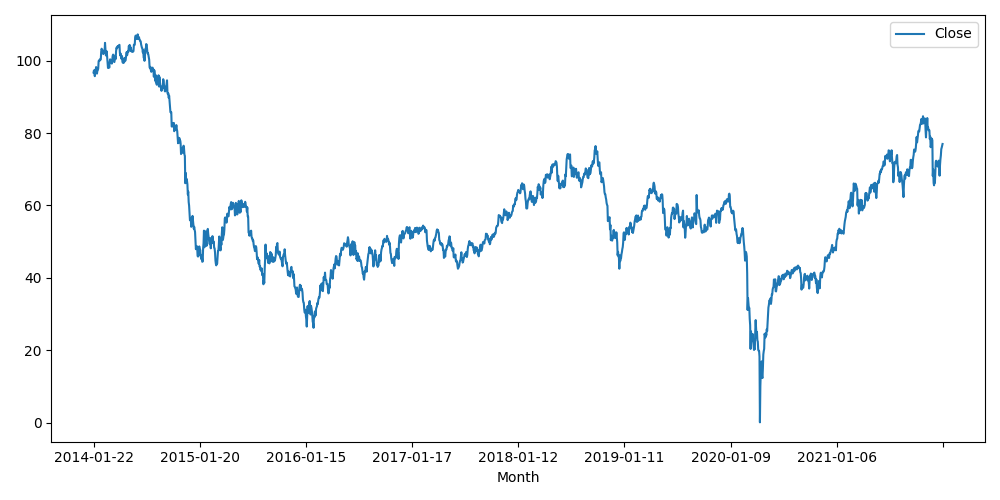

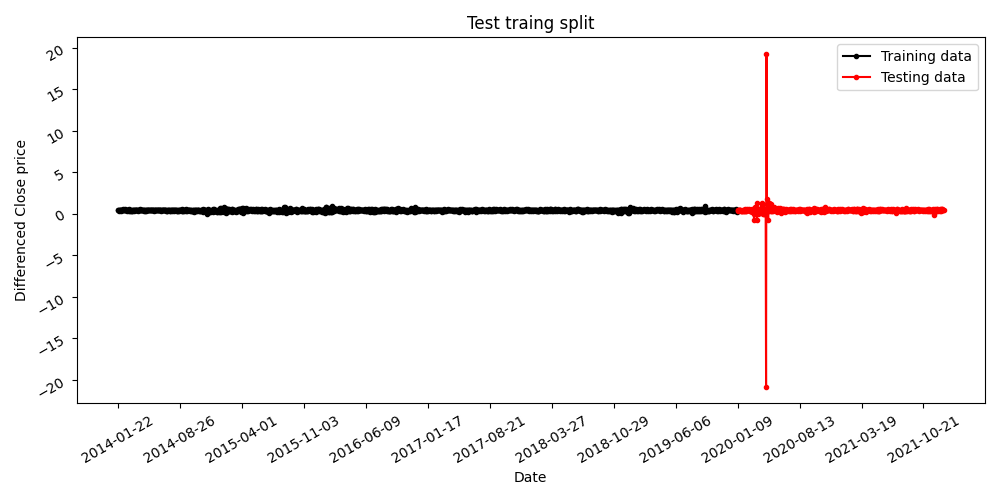

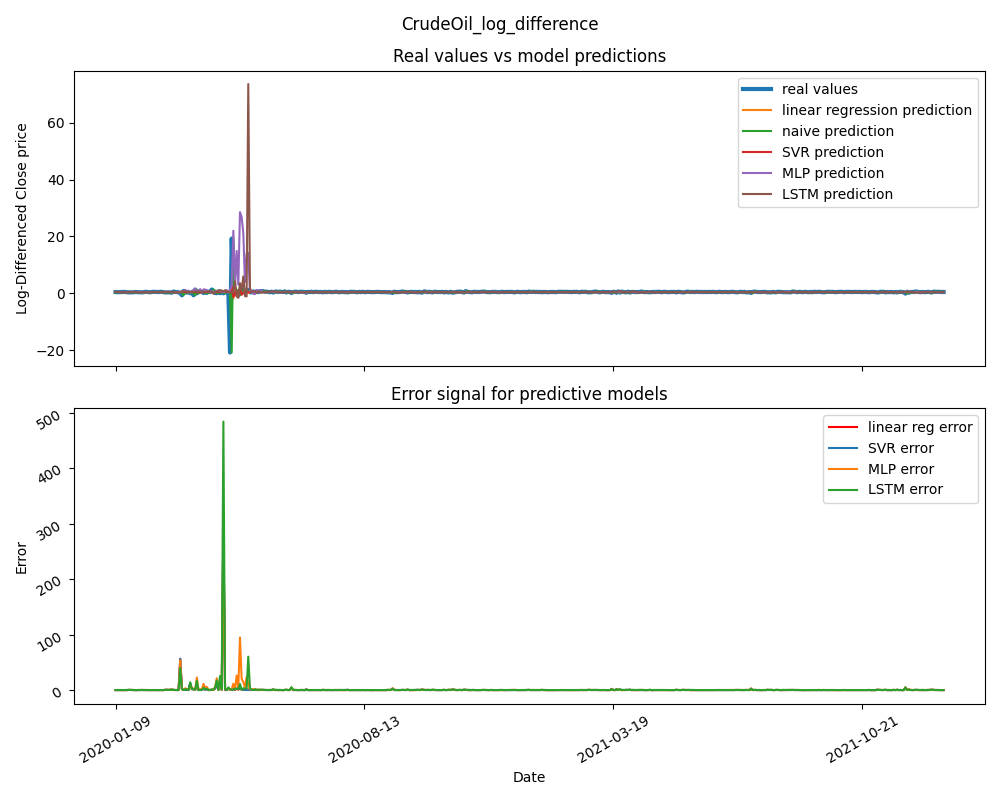

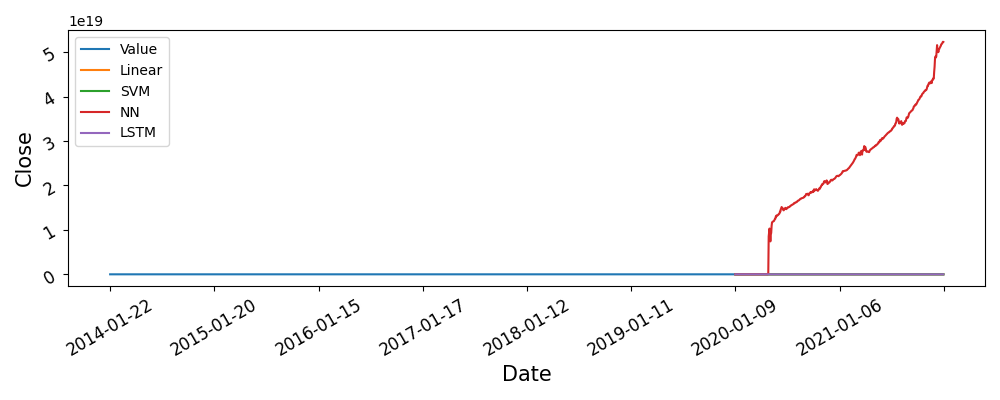

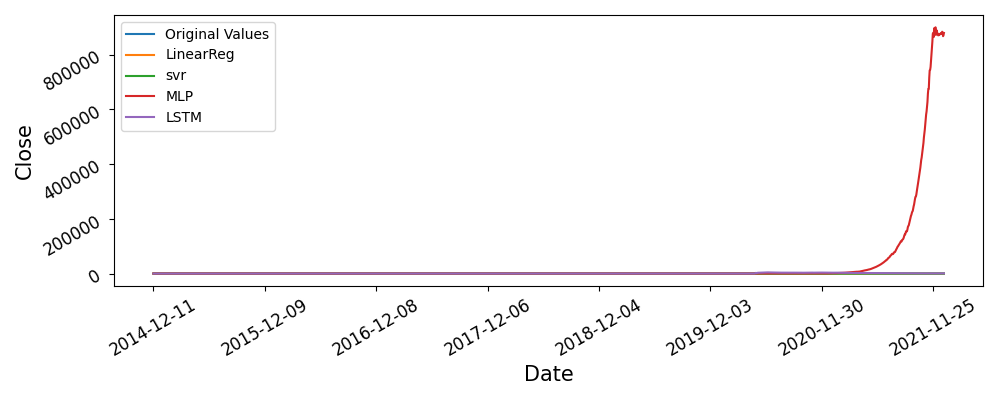

In [14]:
financial_assets = ['CrudeOil']#['S&P500','Apple','EurUsd']#,'CrudeOil'] # ['AirPassengers']#
feat_engineering = 'log_difference'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################
    if financial_asset != 'AirPassengers':
        df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
        df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    else:
        df = pd.read_csv(f'./test_data/{financial_asset}.csv')
        df['Date'] = df['Month'] # for the airplane dataset

    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # feature engineer data
    ###################################################################################################
    df['log'] = df[f'{column_to_predict}'].apply(lambda x: np.log(x))
    df['log_diff'] = df['log'].diff(periods=1)
    df['log_diff'].iloc[0] = 0

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df['log_diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df['log_diff'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=False,n_batch=12)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Log-Differenced Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # invert differencing for different models
    inverted_lin = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
    inverted_svm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_nn = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_lstm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_lin['invert_pred_value'], 
                        svm_pred=inverted_svm['invert_pred_value'], 
                        nn_preds=inverted_nn['invert_pred_value'], 
                        lstm_preds=inverted_lstm['invert_pred_value'],
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane otherwise 225
        test_len = 25   # 12 for Airplane otherwise 25
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    original_series=scaled_input_data,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())
        
        # invert differencing for different models
        inverted_preds = invert_first_difference_with_log_2(
                                first_value=df[f'log'].iloc[train_len],
                                predictions=inverted_predictions,
                                original=df[f'{column_to_predict}'].iloc[train_len:],
                                dates=df['Date'].iloc[train_len:]               
                                        )

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value']))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_preds['invert_pred_value'])

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = inverted_preds['value'].to_numpy()
        model_pred_results[model_name] = inverted_preds['invert_pred_value'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')



array([<AxesSubplot:>], dtype=object)

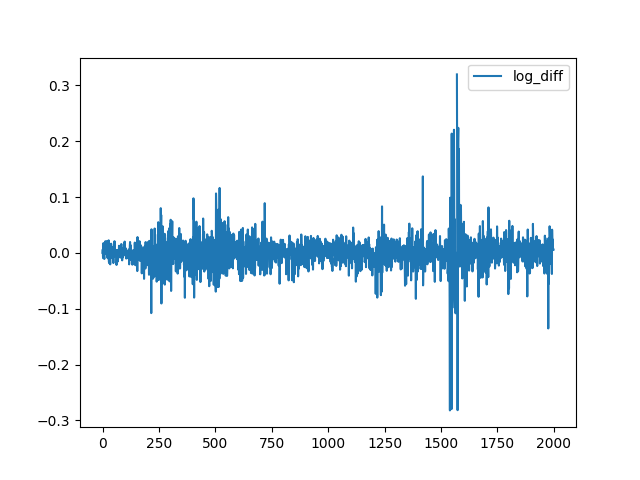

In [6]:
df[['log_diff']].plot(subplots=True)

Some notes:
- the models perform horibly on the Crude Oil dataset. Their predictions out of sample are many orders of magnitude off. I belive this is because normalisation is fit to the training data, and then used to transform the testing data. But becauses durring 2020 there were so many anomaly events, ie crude dropped to zero, this value and its log-returns are so out of the scope of the models that their predictions on it are massively wrong. 
- we cannot predict what it hasnt been seen. 